In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ripanputra","key":"dc5760f51c74d1a8d4e087f02bd48bf3"}'}

In [ ]:
import os
import zipfile

# Buat direktori .kaggle dan pindahkan file ke sana
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set permission
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fathurrahmanalfarizy/sampah-daur-ulang

Dataset URL: https://www.kaggle.com/datasets/fathurrahmanalfarizy/sampah-daur-ulang
License(s): unknown
  0% 0.00/98.5M [00:00<?, ?B/s]
100% 98.5M/98.5M [00:00<00:00, 1.38GB/s]


In [ ]:
with zipfile.ZipFile("sampah-daur-ulang.zip", 'r') as zip_ref:
    zip_ref.extractall("sampah-daur-ulang")

In [ ]:
base_path = "sampah-daur-ulang/DATASETS"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
def prep_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

In [ ]:
def get_dataset_path(base_path):
    classes = sorted(os.listdir(base_path))
    file_paths = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(base_path, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(class_dir, file_name))
                labels.append(i)

    return file_paths, labels, classes

In [ ]:
file_paths, labels, class_names = get_dataset_path(base_path)

print(f"Found {len(file_paths)} images in {len(class_names)} classes.")

Found 7014 images in 6 classes.


In [ ]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

In [ ]:
def create_dataset(file_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(prep_image, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size = 1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_dataset = create_dataset(train_paths, train_labels)
test_dataset = create_dataset(test_paths, test_labels)
val_dataset = create_dataset(val_paths, val_labels)

In [ ]:
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.3)
    img = tf.image.random_contrast(img, lower=0.6, upper=1.4)
    img = tf.image.random_saturation(img, lower=0.6, upper=1.4)
    img = tf.image.random_hue(img, max_delta=0.1)
    return img, label


In [ ]:
def build_model(num_classes):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
    base_model.trainable = True  # Fine-tune seluruh layer

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model


In [ ]:
num_classes = len(class_names)
model = build_model(num_classes)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,590 (9.99 MB)

 Trainable params: 2,585,478 (9.86 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 98s 263ms/step - accuracy: 0.1932 - loss: 2.4515 - val_accuracy: 0.3524 - val_loss: 1.5634 - learning_rate: 1.0000e-05
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.2597 - loss: 1.8644 - val_accuracy: 0.5606 - val_loss: 1.3160 - learning_rate: 1.0000e-05
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.3356 - loss: 1.6018 - val_accuracy: 0.6719 - val_loss: 1.1315 - learning_rate: 1.0000e-05
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.4340 - loss: 1.4326 - val_accuracy: 0.7361 - val_loss: 0.9718 - learning_rate: 1.0000e-05
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.4987 - loss: 1.2679 - val_accuracy: 0.7746 - val_loss: 0.8380 - learning_rate: 1.0000e-05
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.5670 - loss: 1.1293 - val_accuracy: 0.7989 - val_loss: 0.7297 - learning_rate: 1.0000e-05
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 11

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.8664 - loss: 0.4679
Test Accuracy: 87.18%


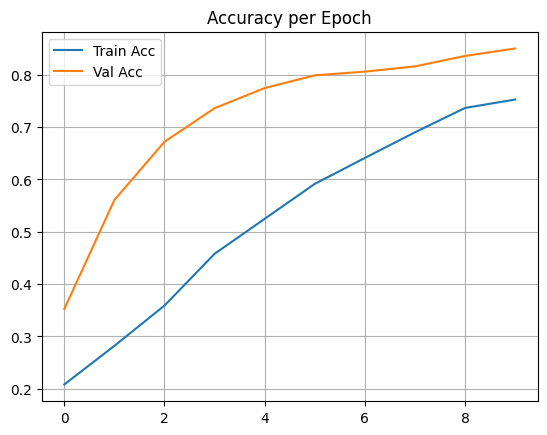

In [ ]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy per Epoch')
plt.grid(True)
plt.show()

In [ ]:
model.save("sampah_classifier.keras")

In [ ]:
from tensorflow.keras.preprocessing import image

📚 Daftar kelas yang dikenali: ['Kaca', 'Kardus', 'Kertas', 'Logam', 'Plastik', 'Residu']
✅ Model berhasil dimuat.
🔼 Silakan unggah gambar...


Saving struk.jpg to struk.jpg

📷 Memproses gambar: struk.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

🔍 Detail Probabilitas:
 - Kaca: 0.44%
 - Kardus: 0.26%
 - Kertas: 93.42%
 - Logam: 0.50%
 - Plastik: 0.25%
 - Residu: 5.13%


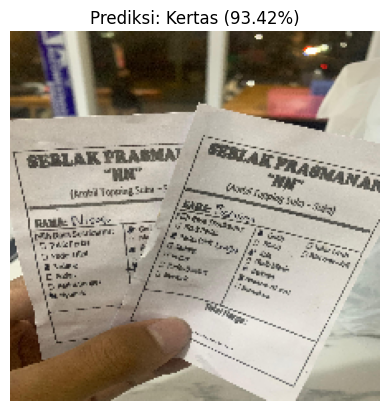

✅ Hasil: KERTAS (93.42%)
➕ Apakah ada gambar lain yang ingin dimasukkan? (ya/tidak): ya
🔼 Silakan unggah gambar...


Saving image-235 (1).png to image-235 (1).png

📷 Memproses gambar: image-235 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

🔍 Detail Probabilitas:
 - Kaca: 0.08%
 - Kardus: 98.10%
 - Kertas: 1.02%
 - Logam: 0.08%
 - Plastik: 0.14%
 - Residu: 0.59%


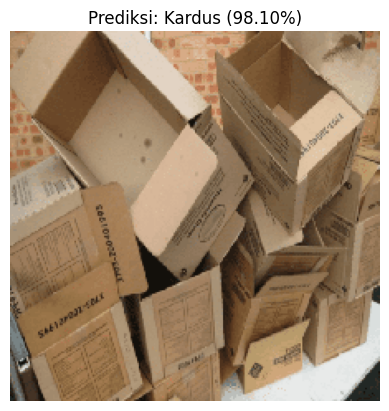

✅ Hasil: KARDUS (98.10%)
➕ Apakah ada gambar lain yang ingin dimasukkan? (ya/tidak): ya
🔼 Silakan unggah gambar...


Saving teh.jpg to teh.jpg

📷 Memproses gambar: teh.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

🔍 Detail Probabilitas:
 - Kaca: 1.94%
 - Kardus: 1.25%
 - Kertas: 2.60%
 - Logam: 7.02%
 - Plastik: 55.29%
 - Residu: 31.89%


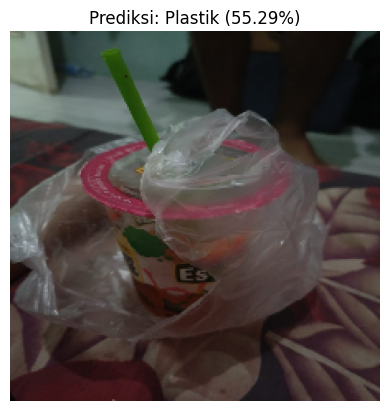

✅ Hasil: PLASTIK (55.29%)
➕ Apakah ada gambar lain yang ingin dimasukkan? (ya/tidak): ya
🔼 Silakan unggah gambar...


Saving kaca.jpg to kaca.jpg

📷 Memproses gambar: kaca.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

🔍 Detail Probabilitas:
 - Kaca: 88.80%
 - Kardus: 0.81%
 - Kertas: 0.58%
 - Logam: 0.49%
 - Plastik: 7.77%
 - Residu: 1.55%


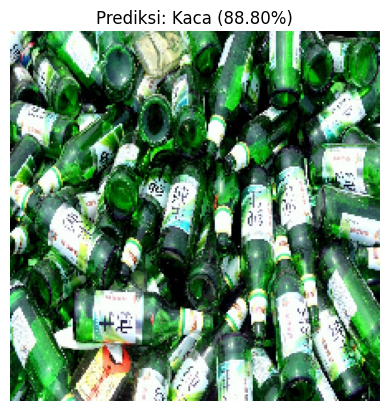

✅ Hasil: KACA (88.80%)
➕ Apakah ada gambar lain yang ingin dimasukkan? (ya/tidak): tidak

📊 Rekapitulasi Sampah:
 - Kaca: 1 buah
 - Kardus: 1 buah
 - Kertas: 1 buah
 - Plastik: 1 buah

💰 Detail Nilai Tukar: 1 Kaca x 200 + 1 Kardus x 500 + 1 Kertas x 0 + 1 Plastik x 100
💵 Total Nilai Tukar: 800 Rupiah


In [ ]:
# --- 1. Parameter dan Setup ---
IMG_SIZE = (224, 224)
DATASET_PATH = "sampah-daur-ulang/DATASETS"
UPLOAD_FOLDER = "sampah"
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

# --- 2. Load class_names berdasarkan folder dataset (pastikan sesuai dengan pelatihan model) ---
class_names = sorted(os.listdir(DATASET_PATH))  # e.g., ['kaca', 'kardus', 'kertas', 'logam', 'plastik', 'residu']
print(f"📚 Daftar kelas yang dikenali: {class_names}")

# --- 3. Load model ---
model = load_model("sampah_classifier.keras")
print("✅ Model berhasil dimuat.")

# --- 4. Fungsi prediksi gambar ---
def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    predictions = model.predict(img_array)[0]
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    confidence = predictions[predicted_index]

    print("\n🔍 Detail Probabilitas:")
    for i, prob in enumerate(predictions):
        print(f" - {class_names[i]}: {prob*100:.2f}%")

    # Tampilkan gambar dan hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class} ({confidence*100:.2f}%)")
    plt.show()

    return predicted_class, confidence

# --- 5. Fungsi perhitungan nilai tukar ---
def calculate_exchange(sampah_count):
    harga_sampah = {
        "Plastik": 100,
        "Kaca": 200,
        "Kardus": 500,
        "Kertas": 0,
        "Logam": 100,
        "Residu": 0
    }

    total_value = 0
    detail = []

    for jenis, jumlah in sampah_count.items():
        if jumlah > 0:
            value = harga_sampah.get(jenis, 0) * jumlah
            detail.append(f"{jumlah} {jenis} x {harga_sampah[jenis]}")
            total_value += value

    detail_str = " + ".join(detail)
    return total_value, detail_str

# --- 6. Proses Input dan Loop Prediksi ---
sampah_count = {jenis: 0 for jenis in class_names}

while True:
    print("🔼 Silakan unggah gambar...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n📷 Memproses gambar: {filename}")
        file_path = os.path.join(UPLOAD_FOLDER, filename)

        # Simpan file ke folder
        with open(file_path, 'wb') as f:
            f.write(uploaded[filename])

        # Prediksi gambar
        predicted_class, confidence = predict_image(file_path)
        print(f"✅ Hasil: {predicted_class.upper()} ({confidence*100:.2f}%)")

        # Tambahkan ke jumlah jenis sampah
        sampah_count[predicted_class] += 1

    # Tanya pengguna apakah ingin menambah gambar lagi
    another = input("➕ Apakah ada gambar lain yang ingin dimasukkan? (ya/tidak): ").strip().lower()
    if another != "ya":
        break

# --- 7. Tampilkan Hasil Akhir ---
print("\n📊 Rekapitulasi Sampah:")
for jenis, jumlah in sampah_count.items():
    if jumlah > 0:
        print(f" - {jenis.capitalize()}: {jumlah} buah")

total_value, detail_str = calculate_exchange(sampah_count)
print(f"\n💰 Detail Nilai Tukar: {detail_str}")
print(f"💵 Total Nilai Tukar: {total_value} Rupiah")
